# Results for experiments with Co-embeddings

In [1]:
%matplotlib inline
import numpy
import pandas
import pickle
import os
import re

from sklearn import metrics

In [2]:
import seaborn
seaborn.set_style('white')

In [3]:
EXPERIMENTS_DIRS = [
    '/home/mteruel/edm/results/dkt_lstm/coembeddings/predictions/test1',
    '/home/mteruel/edm/results/dkt_lstm/coembeddings/predictions/test2',
    '/home/mteruel/edm/results/dkt_lstm/coembeddings/predictions/test3',
]

In [4]:
def get_runs(dirname):
    return [run_prediction for run_prediction in os.listdir(dirname)
            if os.path.isfile(os.path.join(dirname, run_prediction)) and 'prediction' in run_prediction]

In [5]:
def base_metrics_df():
    return pandas.DataFrame(columns=['Experiment', 'Run',
                                     'AUC-mean', 'RMSE-mean', 'APS-mean', 'Accuracy-mean', 'R2-mean',
                                     'AUC-std', 'RMSE-std', 'APS-std', 'Accuracy-std', 'R2-std'])

In [6]:
def read_file_metrics(filename):
    """Returns a DataFrame with values Sequence length, AUC, RMSE, APS, Accuracy, R2 Score"""
    results = []
    ignored_sequences = 0
    with open(filename, 'r') as prediction_file:
        true, predicted = pickle.load(prediction_file)
    for true_sequence, predicted_sequence in zip(true, predicted):
        results.append([true_sequence.shape[0]])
        try:
            results[-1].append(metrics.roc_auc_score(true_sequence, predicted_sequence))
        except ValueError:
            ignored_sequences += 1
            results[-1].append(numpy.nan)
        results[-1].append(metrics.mean_squared_error(true_sequence, predicted_sequence)**0.5)
        results[-1].append(metrics.average_precision_score(true_sequence, predicted_sequence))
        results[-1].append(metrics.accuracy_score(true_sequence, numpy.where(predicted_sequence > 0.5, 1, 0)))
        results[-1].append(metrics.r2_score(true_sequence, predicted_sequence))
        
    print '{} sequences with only one class, ignoring.'.format(ignored_sequences)
    return pandas.DataFrame(results, columns=['Sequence lenght', 'AUC', 'RMSE', 'APS', 'Accuracy', 'R2'])

In [7]:
def read_averaged_metrics(filename, metrics_df, columns=['AUC', 'RMSE', 'APS', 'Accuracy', 'R2']):
    """Generates a single dataset with the mean ans std of metrics dataframes."""
    results = {}
    file_metrics = read_file_metrics(filename)
    results['Experiment'] = os.path.basename(os.path.dirname(filename)[-20:])
    results['Run'] = re.search('.*run(\d+).*', filename).group(1)
    for column in columns:
        results[column + '-mean'] = file_metrics[column].mean()
        results[column + '-std'] = file_metrics[column].std()
    metrics_df.loc[metrics_df.shape[0]] = results
    return metrics_df

In [8]:
def raw_metrics(dirnames):
    metrics_dfs = []
    for dirname in dirnames:
        for filename in get_runs(dirname):
            file_metrics = read_file_metrics(os.path.join(dirname, filename))
            file_metrics['Experiment'] = os.path.basename(dirname)[-20:]
            file_metrics['Run'] = re.search('.*run(\d+).*', filename).group(1)
            metrics_dfs.append(file_metrics)
    return pandas.concat(metrics_dfs, ignore_index=True)

In [17]:
def averaged_metrics(dirnames):
    metrics_df = base_metrics_df()
    for dirname in dirnames:
        for filename in get_runs(dirname):
            metrics_df = read_averaged_metrics(os.path.join(dirname, filename), metrics_df)
    return metrics_df

In [10]:
raw_results = raw_metrics(EXPERIMENTS_DIRS)

114 sequences with only one class, ignoring.
91 sequences with only one class, ignoring.
100 sequences with only one class, ignoring.
112 sequences with only one class, ignoring.
118 sequences with only one class, ignoring.
101 sequences with only one class, ignoring.
106 sequences with only one class, ignoring.
132 sequences with only one class, ignoring.


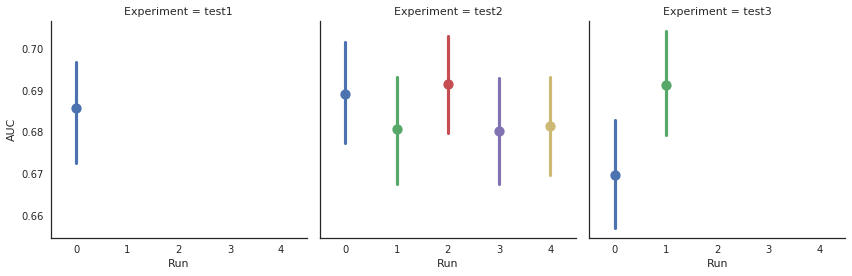

In [11]:
seaborn.factorplot(data=raw_results, y='AUC', hue='Run', x='Run', join=False, col='Experiment')

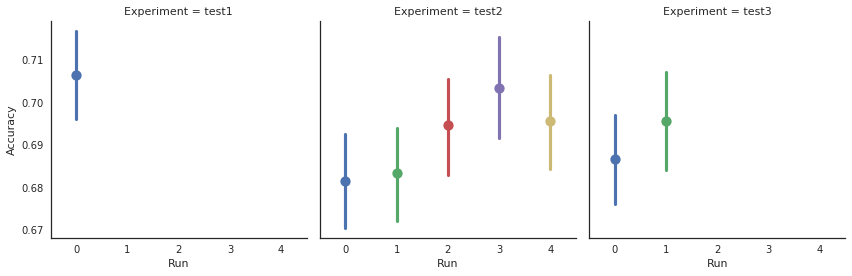

In [12]:
seaborn.factorplot(data=raw_results, y='Accuracy', hue='Run', x='Run', join=False, col='Experiment')

In [18]:
averaged_results = averaged_metrics(EXPERIMENTS_DIRS)

114 sequences with only one class, ignoring.
91 sequences with only one class, ignoring.
100 sequences with only one class, ignoring.
112 sequences with only one class, ignoring.
118 sequences with only one class, ignoring.
101 sequences with only one class, ignoring.
106 sequences with only one class, ignoring.
132 sequences with only one class, ignoring.


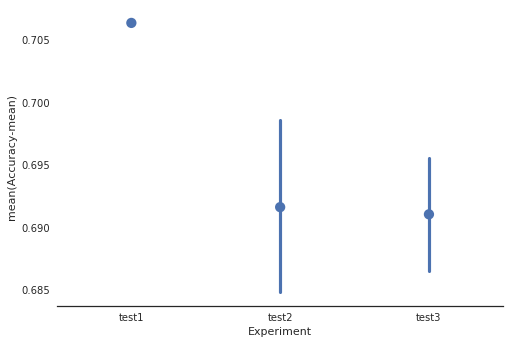

In [19]:
seaborn.pointplot(data=averaged_results, x='Experiment', y='Accuracy-mean', join=False)
seaborn.despine(left=True)

In [26]:
lala = averaged_results.groupby('Experiment')
lala.aggregate('mean')

,AUC-mean,RMSE-mean,APS-mean,Accuracy-mean,R2-mean,AUC-std,RMSE-std,APS-std,Accuracy-std,R2-std
Experiment,,,,,,,,,,
test1,0.685631,0.421425,0.823391,0.706333,-0.230816,0.161666,0.124711,0.173515,0.159272,1.105138
test2,0.684565,0.428812,0.831963,0.691604,-0.244720,0.169782,0.125334,0.151246,0.161014,0.954841
test3,0.680405,0.426463,0.828689,0.691031,-0.296345,0.166442,0.134843,0.156940,0.165242,1.200540
